# New(?) indexing approach

_Isthums_

This notebook is a minimum viable demonstration of a concise and efficient approach for representing rings, with both size and privacy benefits, that is `O(1)` with ring size. Given a transaction with `N_in` inputs, all ring members positions in all rings can be represented by  a `N_in + 1` length tuple of integers:

`(anchor index, ring 1 marker, ring 1 marker, ... ring N_in marker)`

The below demonstration uses the size of a `uint32` for both the anchor `h` and the range of the ring markers `[0, u)`, so the total size of representing all rings is `4 * (N_in + 1)` bytes.

## How it works:
Let the outputs in the settled chain be numbered x=1, x=2, x=3, ...

We wish to construct a single ring, spending output `x_true`.

The ring member positions will be completely described by: `(anchor, marker)`

The `anchor` is just the number of outputs in the chain as of 10 blocks ago.

To find the marker, we divide the area under the RMSA into `r` windows with the same **area**. We jump straight to the window `(window_start, window_stop)` containing the true spend and calculate its `index_in_window` which is (`x_true - window_start`).

We pick a random integer `k` up to `u // (window_stop - window_start)` and then publish the "marker", calculated as:

`marker = k * (window_stop - window_start) + index_in_window`

On the other side, anybody can parse `(anchor, marker)` into the full set of ring members by iterating over each of the `r` windows, and calculating the overall index of its ring member as:

`ring_member_ith_window: int = window_i_start + (marker % (window_i_stop - window_i_start))`

## Benefits

+ Potentially more space efficient
+ O(1) with ring size. (actually higher ring sizes can lead to tighter representations)
+ Every ring of every transaction will have members distributed according to the RMSA
+ **This will kill essentially every chainanalysis heuristic based on ring member sampling or reuse**

## Demo simplifications

To demonstrate that this works for arbitrary DSA/RMSA's, I picked a silly foobar RMSA that defies analytic analysis. In practice, with a rational RMSA, there may be much more efficient ways to invert the distribution to windows. To demonstrate the principle as simply as possible, I sample directly from the output space, but the RMSA could sample from height space instead. Likewise, the anchor could be specified as a block index (height) instead of output index. A production implementation would probably adjust the windowing function to use strictly integer math under the hood. (pretty much everything else is purely integer arithmetic already)

## Demo

In [1]:
import random
from typing import List, Tuple

import isthmuslib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

### Setup

Define our consensus constants, including the ring size `r` and the range of the ring markers `[0, u)`

In [2]:
# CONSENSUS CONSTANTS:
u: int = 2 ** 32  # uint32
r: int = 16


I'll define some arbitrary ring member selection algorithm (RMSA) that produces a set of R output indices.

The RMSA is like a decoy selection algorithm (DSA). The only difference is that a DSA returns R-1 decoy indices (excluding the real spend) and the RMSA returns R indices (including the real spend).

To show that this indexing approach is not dependent on any particular form of RSA, I'll define it as a kind of absurd amalgamation of functions.

In [3]:
def foobar_RMSA(x: int, h: int) -> float:
    b: int = 500_000
    if x < h - b:
        slope: float = 5 / (h - b)
        return slope * x + 5
    elif x >= 750_000:
        slope: float = (100 - 10) / b
        intercept: float = 10 - slope * (h - b)
        period: float = b * 0.8
        return (slope * x + intercept) + 20 * np.sin(2 * np.pi * (x - 750_000) / period)
    else:
        slope: float = (100 - 10) / b
        intercept: float = 10 - slope * (h - b)
        return slope * x + intercept

Plot the RMSA for an output set with 1 million indices

In [4]:
demo_anchor: int = 1_000_000

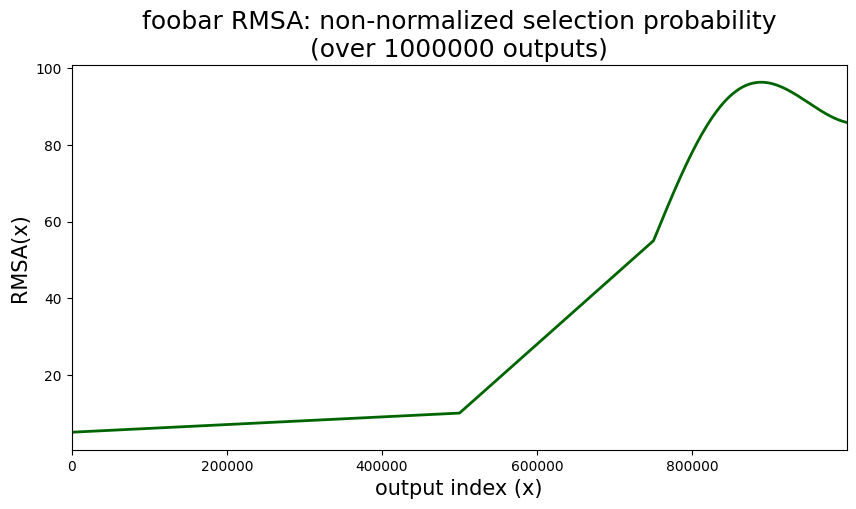

In [5]:
plot_downsample_factor: int = 1000
isthmuslib.plot(
    list(range(1_000_000))[::plot_downsample_factor],
    [foobar_RMSA(x, demo_anchor) for x in range(1_000_000)][::plot_downsample_factor],
    multi=False,
    xlabel="output index (x)",
    ylabel="RMSA(x)",
    grid=False,
    figsize=(10, 5),
    title=f'foobar RMSA: non-normalized selection probability\n(over {demo_anchor} outputs)',
    show=True,
    downsample=1000,
    linewidth=2,
);

## Building a ring

Let's say we want to construct a ring that contains our true spend, output 777,777

In [6]:
x_true: int = 777_777

## Step 1: Windowing

Break the area under the RMSA curve into `r` even parts

In [7]:
def get_windows(r: int, h: int) -> List[Tuple[int, int]]:
    # Estimate the area of each window
    total_area, _ = quad(lambda x: foobar_RMSA(x, h), 0, h)  # noqa: syntax is OK
    target_area = total_area / r

    # Iterate over windows to determine boundaries
    windows: List[Tuple[int, int]] = []
    start_x: int = 0
    for i in range(r):
        area_func = lambda end_x: quad(lambda x: foobar_RMSA(x, h), start_x, end_x)[0] - target_area
        end_x = start_x + target_area  # Initial guess
        end_x = fsolve(area_func, end_x)[0]  # Use numerical solver to find end_x

        # Match to integer domain and save
        end_x = round(end_x)
        if i < r - 1:
            end_x -= 1
        windows.append((int(start_x), int(end_x)))
        start_x = end_x + 1

    return windows


windows: List[Tuple[float, float]] = get_windows(r, demo_anchor)
print(f"Windows: {windows}")

Windows: [(0, 317186), (317187, 532995), (532996, 620660), (620661, 677388), (677389, 722785), (722786, 761396), (761397, 792158), (792159, 818244), (818245, 841893), (841894, 864252), (864253, 886036), (886037, 907754), (907755, 929800), (929801, 952465), (952466, 975895), (975896, 999999)]


Visualize the windows

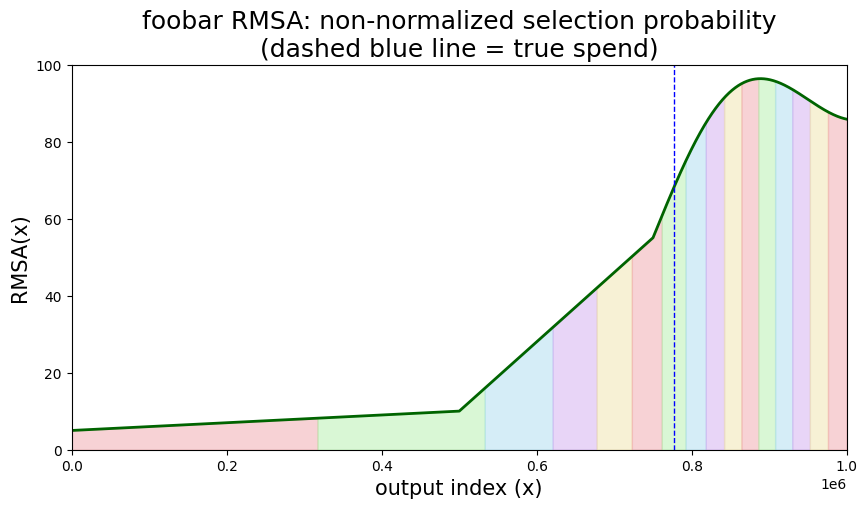

In [8]:
def window_plot_helper(h: int, r: int):
    # Get the RMSA and window values
    x_values: List[float] = list(np.arange(0, h + 1))
    y_values: List[float] = list(np.array([foobar_RMSA(x, h) for x in x_values]))
    windows: List[Tuple[float, float]] = get_windows(r, h)

    isthmuslib.plot(
        x_values,
        y_values,
        xlabel="output index (x)",
        ylabel="RMSA(x)",
        grid=False,
        figsize=(10, 5),
        title=f'foobar RMSA: non-normalized selection probability\n(dashed blue line = true spend)',
        show=False,
        downsample=1000,
        linewidth=2,
        ylim=(0, 100),
    )

    # Shade the area under the curve based on the window
    colors: List[str] = ["#f0a6ad", "#b4f0ad", "#adddf0", "#d2adf0", "#f0e4ad"]
    for i, (start_x, end_x) in enumerate(windows):
        plt.fill_between(
            x_values[start_x:end_x + 1],
            y_values[start_x:end_x + 1],
            color=colors[i % len(colors)],
            alpha=0.5)
    plt.axvline(x=x_true, color="blue", linestyle="--", linewidth=1)
    plt.show()


windows: List[Tuple[float, float]] = get_windows(r, demo_anchor)
window_plot_helper(demo_anchor, r)

## Step 2: Find the marker

In [9]:
def get_marker_value(true_index: int) -> int:
    # Find the window that contains the true spend
    for window_index, (start_x, end_x) in enumerate(windows):
        if start_x <= true_index <= end_x:
            break
    else:
        raise ValueError("True spend not in any window")

    # Calculate the marker
    window_left, window_right = windows[window_index]
    window_width = window_right - window_left
    index_in_window = true_index - window_left
    random.seed(42)  # make _demo_ reproducible
    random_k: int = random.randint(0, u // window_width)
    return random_k * window_width + index_in_window

In [10]:
marker: int = get_marker_value(x_true)
print(f"Marker value: {marker}")

Marker value: 897745404


## Step 3: Demo mapping (anchor, marker) to all ring members

In [11]:
def get_ring_members(anchor: int, marker: int) -> List[int]:
    # Get the windows
    windows: List[Tuple[int, int]] = get_windows(r, anchor)

    # Identify the [global] index of the ring member in each window
    ring_member_indices: List[int] = []
    for w_start, w_end in windows:
        window_width: int = w_end - w_start
        output_index_in_window: int = marker % window_width
        ring_member_indices.append(w_start + output_index_in_window)

    return ring_member_indices

In [12]:
ring_members: List[int] = get_ring_members(demo_anchor, marker)
print(f"Ring members: {ring_members}")

Ring members: [109024, 517119, 599040, 661290, 716893, 747080, 777777, 796203, 838273, 846524, 866878, 894095, 914624, 931501, 968877, 980962]


Visualize the ring members

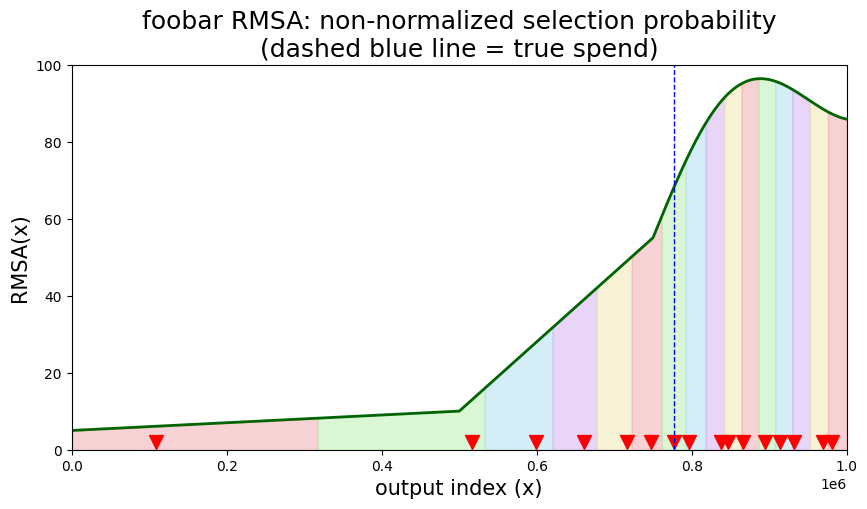

In [13]:
def ring_plot_helper(h: int, r: int):
    # Get the RMSA and window values
    x_values: List[float] = list(np.arange(0, h + 1))
    y_values: List[float] = list(np.array([foobar_RMSA(x, h) for x in x_values]))
    windows: List[Tuple[float, float]] = get_windows(r, h)

    isthmuslib.plot(
        x_values,
        y_values,
        xlabel="output index (x)",
        ylabel="RMSA(x)",
        grid=False,
        figsize=(10, 5),
        title=f'foobar RMSA: non-normalized selection probability\n(dashed blue line = true spend)',
        show=False,
        downsample=1000,
        linewidth=2,
        ylim=(0, 100),
    )

    # Shade the area under the curve based on the window
    colors: List[str] = ["#f0a6ad", "#b4f0ad", "#adddf0", "#d2adf0", "#f0e4ad"]
    for i, (start_x, end_x) in enumerate(windows):
        plt.fill_between(
            x_values[start_x:end_x + 1],
            y_values[start_x:end_x + 1],
            color=colors[i % len(colors)],
            alpha=0.5)
        
    # Indicate the true spend
    plt.axvline(x=x_true, color="blue", linestyle="--", linewidth=1)
    plt.scatter(ring_members, [2] * len(ring_members), color="red", s=100, marker="v")
    plt.show()


ring_plot_helper(demo_anchor, r)

## Show that this worked correctly

Is the true spend in the ring?

In [14]:
if x_true in ring_members:
    print(f"Yes, {x_true} is in the ring:\n{ring_members}")

Yes, 777777 is in the ring:
[109024, 517119, 599040, 661290, 716893, 747080, 777777, 796203, 838273, 846524, 866878, 894095, 914624, 931501, 968877, 980962]


Does the distribution of ring members match the RMSA?

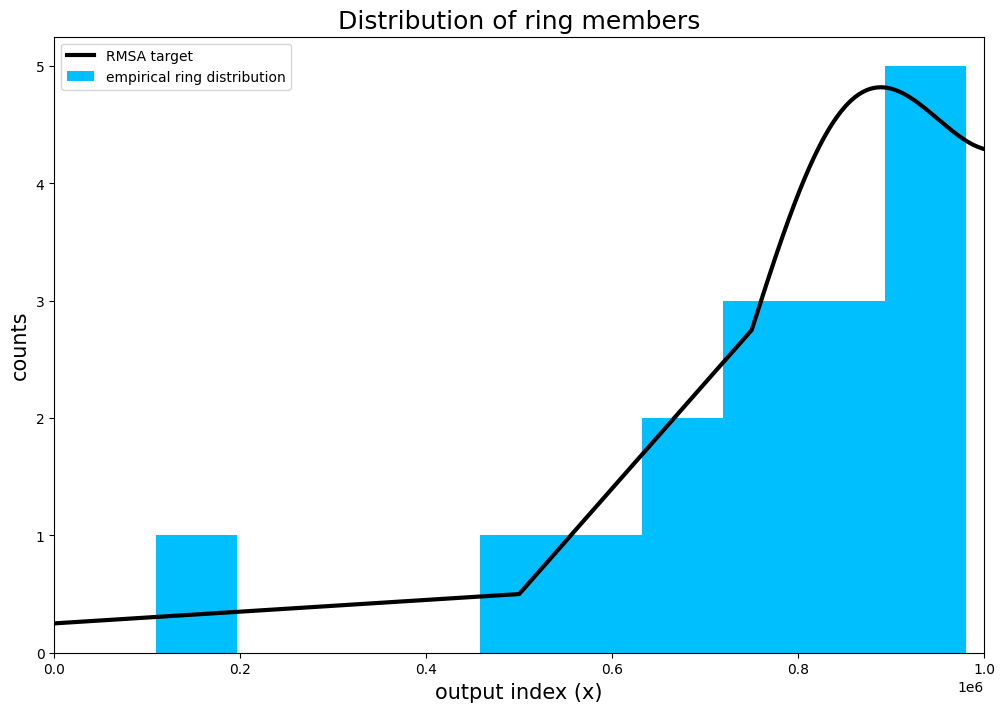

In [15]:
isthmuslib.hist(
    ring_members,
    title="Distribution of ring members",
    show=False,
    xlabel="output index (x)",
    color='deepskyblue'
)
range_downsampled: List[float] = list(np.arange(0, demo_anchor + 1, 1000))
plt.plot(
    range_downsampled,
    list(np.array([foobar_RMSA(x, demo_anchor) / 20 for x in range_downsampled])),
    color="k",
    linewidth=3,
)
plt.legend(['RMSA target', 'empirical ring distribution']);